In [1]:
from preprocess import preprocess_data_flat
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer, accuracy_score, balanced_accuracy_score, roc_auc_score
from tabulate import tabulate 

In [2]:
X_train_flat, y_train_flat = preprocess_data_flat("2", 30)
X_test_flat, y_test_flat = preprocess_data_flat("1", 30)

In [3]:
model = ExtraTreesClassifier(random_state=123)

param_dist = {
    "max_depth": [2, 3, 4, 5, 6],
    "n_estimators": [300, 500, 700, 900, 1100],
    "min_samples_split": [2, 5, 8, 10],
    "min_samples_leaf": [1, 2, 4, 6],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy", "log_loss"],
    "class_weight": ["balanced", "balanced_subsample", None],
    "max_samples": [0.6, 0.7, 0.8, 0.9, 1.0]
}

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    scoring="balanced_accuracy",
    cv=cv,
    random_state=123,
    n_jobs=10,
    refit="balanced_accuracy",
    verbose=0,
)

random_search.fit(X_train_flat, y_train_flat)
best_model = random_search.best_estimator_

/Users/nicolasgutierrez/Documents/Thesis/data_processing/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nicolasgutierrez/Documents/Thesis/data_processing/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nicolasgutierrez/Documents/Thesis/data_processing/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nicolas

In [4]:
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "roc_auc": make_scorer(roc_auc_score),
    "f1": make_scorer(f1_score),
}


cv_results = cross_validate(
    best_model,
    X_train_flat,
    y_train_flat,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)


fold_results = []
for i in range(n_splits):
    fold_results.append(
        {
            "Fold": i + 1,
            "Train Acc": f"{cv_results['train_accuracy'][i]:.4f}",
            "Test Acc": f"{cv_results['test_accuracy'][i]:.4f}",
            "Train BA": f"{cv_results['train_balanced_accuracy'][i]:.4f}",
            "Test BA": f"{cv_results['test_balanced_accuracy'][i]:.4f}",
            "Train AUC": f"{cv_results['train_roc_auc'][i]:.4f}",
            "Test AUC": f"{cv_results['test_roc_auc'][i]:.4f}",
            "Train F1": f"{cv_results['train_f1'][i]:.4f}",
            "Test F1": f"{cv_results['test_f1'][i]:.4f}",
            "Time (s)": f"{cv_results['fit_time'][i] + cv_results['score_time'][i]:.3f}",
        }
    )

summary_results = {
    "F1 Score": f"{cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}",
    "Accuracy": f"{cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}",
    "Balanced Accuracy": f"{cv_results['test_balanced_accuracy'].mean():.4f} ± {cv_results['test_balanced_accuracy'].std():.4f}",
    "ROC AUC": f"{cv_results['test_roc_auc'].mean():.4f} ± {cv_results['test_roc_auc'].std():.4f}",
    "Total Time (s)": f"{(cv_results['fit_time'] + cv_results['score_time']).sum():.3f}",
}

print("\n" + "=" * 80)
print("CROSS-VALIDATION RESULTS")
print("=" * 80)

print("\n RESULTS BY FOLD:")
print(tabulate(fold_results, headers="keys", tablefmt="pretty"))

print("\n STATISTICS (Test Set within CV):")
for metric, value in summary_results.items():
    print(f"   • {metric:<20}: {value}")


print("\n" + "=" * 80)
print("FINAL EVALUATION ON HELD-OUT TEST SET")
print("=" * 80)
y_pred_test = best_model.predict(X_test_flat)
y_prob_test = best_model.predict_proba(X_test_flat)[:, 1]

test_f1 = f1_score(y_test_flat, y_pred_test)
test_accuracy = accuracy_score(y_test_flat, y_pred_test)
test_balanced_accuracy = balanced_accuracy_score(y_test_flat, y_pred_test)
test_roc_auc = roc_auc_score(y_test_flat, y_prob_test)

print(f"   • {'F1 Score':<20}: {test_f1:.4f}")
print(f"   • {'Accuracy':<20}: {test_accuracy:.4f}")
print(f"   • {'Balanced Accuracy':<20}: {test_balanced_accuracy:.4f}")
print(f"   • {'ROC AUC':<20}: {test_roc_auc:.4f}")
print("=" * 80)


CROSS-VALIDATION RESULTS

 RESULTS BY FOLD:
+------+-----------+----------+----------+---------+-----------+----------+----------+---------+----------+
| Fold | Train Acc | Test Acc | Train BA | Test BA | Train AUC | Test AUC | Train F1 | Test F1 | Time (s) |
+------+-----------+----------+----------+---------+-----------+----------+----------+---------+----------+
|  1   |  0.9676   |  0.9149  |  0.9647  | 0.9048  |  0.9647   |  0.9048  |  0.9714  | 0.9286  |  0.296   |
|  2   |  0.9730   |  0.8936  |  0.9695  | 0.8947  |  0.9695   |  0.8947  |  0.9763  | 0.9020  |  0.299   |
|  3   |  0.9946   |  0.8913  |  0.9939  | 0.8810  |  0.9939   |  0.8810  |  0.9952  | 0.9091  |  0.304   |
|  4   |  0.9839   |  0.9348  |  0.9819  | 0.9250  |  0.9819   |  0.9250  |  0.9856  | 0.9455  |  0.307   |
|  5   |  0.9946   |  0.8913  |  0.9940  | 0.8750  |  0.9940   |  0.8750  |  0.9952  | 0.9123  |  0.299   |
+------+-----------+----------+----------+---------+-----------+----------+----------+-----

   • Balanced Accuracy   : 0.4916
   • ROC AUC             : 0.4462


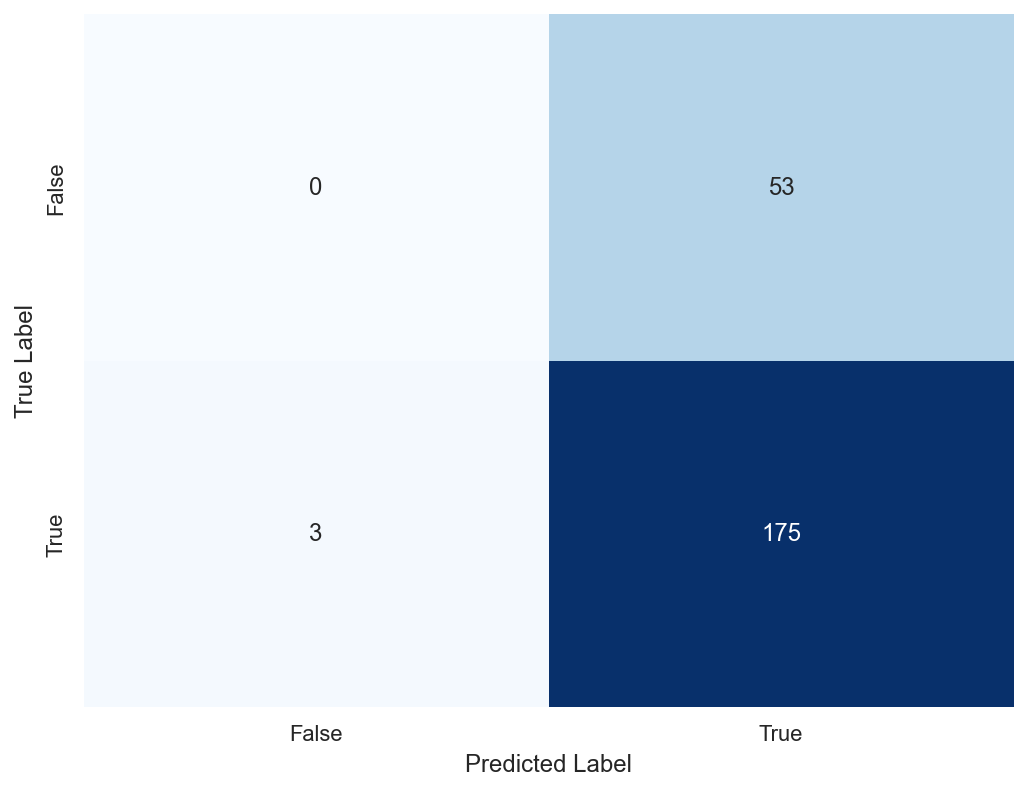

In [11]:
print(f"   • {'Balanced Accuracy':<20}: {test_balanced_accuracy:.4f}")
print(f"   • {'ROC AUC':<20}: {test_roc_auc:.4f}")
print("=" * 80)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Apply styling
plt.style.use("seaborn-v0_8-white")
sns.set_style("white")
sns.set_palette("colorblind")
sns.set_context("paper", font_scale=1.2)

# Generate confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6), dpi=150)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("figures/Confusion.png")

In [12]:
cm


array([[  0,  53],
       [  3, 175]])